In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

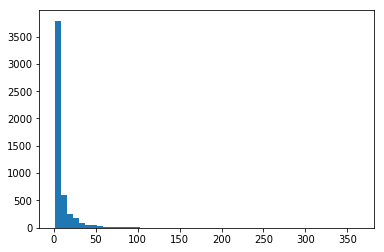

In [3]:
plt.hist(df.email.value_counts(),bins=50);

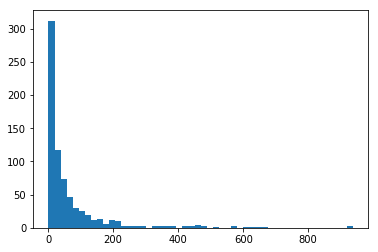

In [4]:
plt.hist(df.article_id.value_counts(),bins=50);

In [5]:
# Finding the median and maximum number of user_article interactios below

median_val = df.email.value_counts().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.email.value_counts().max() # The maximum number of user-article interactions by any 1 user 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
df_content.article_id.drop_duplicates(inplace=True)

In [7]:
df_content.article_id.duplicated().sum()

0

`3.` Using the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.shape[0]# The number of unique articles on the IBM platform
unique_users = df.email.nunique()# The number of unique users
user_article_interactions = df.email.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
most_viewed_article_id = str(df.article_id.value_counts().idxmax()) #The most viewed article in the dataset as a string 
max_views = df.article_id.value_counts().max()# How many times the most viewed article in the dataset was viewed

In [10]:
# Mapp the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    title_count=df.title.value_counts().reset_index()
    
    top_titles=title_count.iloc[:n,0]
    
    return top_titles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''   
    article_count=df.article_id.value_counts().reset_index()
    
    top_articles=article_count.iloc[:n,0]
 
    return top_articles # Return the top article ids

In [13]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Using the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then 1 will be placed where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article will be a 1.  


* **If a user has not interacted with an item, then a zero will be placed where the user-row meets for that article-column**. 



In [14]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_article=df.groupby(['user_id','article_id'])['title'].max().unstack()
    
    user_item=user_article.applymap(lambda x: 1 if len(str(x))>3 else 0)
    
    return user_item 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 



In [16]:
dot_prod_users=user_item.dot(user_item.transpose())

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''

    # create list of just the ids
    similar_ids=dot_prod_users.loc[user_id].sort_values(ascending=False).reset_index()
    # remove the own user's id
    similar_ids.drop(similar_ids.index[similar_ids['user_id']==similar_ids.columns[1]], axis = 0, inplace=True)
    
    most_similar_users=similar_ids.iloc[:,0]
       
    return most_similar_users # returning a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: 1     3933
2       23
3     3782
4      203
5     4459
6      131
7     3870
8       46
9     4201
10    5041
Name: user_id, dtype: int64
The 5 most similar users to user 3933 are: 0       1
2      23
3    3782
4    4459
5     203
Name: user_id, dtype: int64
The 3 most similar users to user 46 are: 0    4201
2      23
3    3782
Name: user_id, dtype: int64


`3.` Using the previous dataframe to find articles we can recommend.  

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_df=df.groupby(['article_id','title'])['user_id'].max().reset_index().iloc[:,:2]
    article_ids=np.array(article_ids)
    article_list= article_ids.astype(float)
    
    
    
    final_list=[]
    for x in range(article_df.shape[0]):
        if article_df['article_id'][x]  in article_list:
            final_list.append(article_df['title'][x])


    
    return final_list # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
        
    df_articles=user_item.iloc[(user_id-1),:].reset_index()
    
    article_ids=[]
    
    for x in range(df_articles.shape[0]):
        if df_articles.iloc[:,1][x]==1:
            article_ids.append(df_articles.iloc[:,0][x])
    article_names=get_article_names(article_ids,df)
    article_ids_str=[str(j) for j in article_ids]
    
    return article_ids_str ,article_names # returning the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    similar_users=find_similar_users(user_id)
    user_articles_id=np.array(get_user_articles(user_id))
    recs=[]
    
    for x in similar_users:
        if len(recs)<10:
            other_articles_id=np.array(get_user_articles(x))

            new_recs=np.setdiff1d(other_articles_id,user_articles_id,assume_unique=False)
            recs=np.unique(np.concatenate([new_recs,recs], axis=0))
     
            
       

    return recs # returning recommendations for this user_id    

In [20]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [21]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    similar_ids=dot_prod_users.loc[user_id].sort_values(ascending=False).reset_index()
    # remove the own user's id
    similar_ids.drop(similar_ids.index[similar_ids['user_id']==similar_ids.columns[1]], axis = 0, inplace=True)
    df_interactions=df.groupby(['user_id']).count()['article_id'].sort_values(ascending=False).reset_index().rename(columns={'article_id':'num_interactions'})
    
    df_neighbor=pd.merge(similar_ids,df_interactions,on='user_id')
    
    sorted_df=df_neighbor.sort_values([df_neighbor.columns[1],df_neighbor.columns[2]],ascending=False)
    
    return sorted_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    
    similar_users=get_top_sorted_users(user_id, df=df, user_item=user_item)
    user_articles_id,user_article_names=get_user_articles(user_id)
    recs=[]
    rec_names=[]
    
    for x in similar_users.user_id:
        if len(recs)< 1:
            other_articles_id, other_article_names =get_user_articles(x)

            new_recs=np.setdiff1d(other_articles_id,user_articles_id,assume_unique=False)
            recs=np.unique(np.concatenate([new_recs,recs], axis=0))
    for y in recs:
        rec_name=get_article_names(y)
        rec_names.append(rec_name)
    
    return recs[:m], rec_names[:m]

In [22]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
[['using deep learning to reconstruct high-resolution audio'], ['airbnb data for analytics: chicago listings'], ['tensorflow quick tips'], ['airbnb data for analytics: venice calendar'], ['airbnb data for analytics: venice listings'], ['airbnb data for analytics: venice reviews'], ['airbnb data for analytics: vienna calendar'], ['airbnb data for analytics: vienna listings'], ['airbnb data for analytics: washington d.c. listings'], ['analyze accident reports on amazon emr spark']]


In [23]:
### Tests with a dictionary of results

user1_most_sim =get_top_sorted_users(131).iloc[0,0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9,0] # Find the 10th most similar user to user 131

## This test has a mistake in the code, probably outdated. Also the values don't match

In [24]:
# ## Dictionary Test Here
# sol_5_dict = {
#     'The user that is most similar to user 1.': user1_most_sim, 
#     'The user that is the 10th most similar to user 131': user131_10th_sim,
# }

# t.sol_5_test(sol_5_dict)

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

#### Answer:

If we face a new user, we will not have any previous connection to other users, the recommendations would then be picking from the top from the list of the sorted top articles and we can use : get_top_article

In [25]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
top_articles=get_top_article_ids(10, df=df)
top_articles_str=[str(x) for x in top_articles]
new_user_recs = top_articles_str



In [26]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [27]:
# Load user item the matrix 
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [28]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix. 

In [29]:
# Performing SVD on the User-Item Matrix

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Looking at the dataframe, there are no missing values which would work well with SVD.

`3.`Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix. 

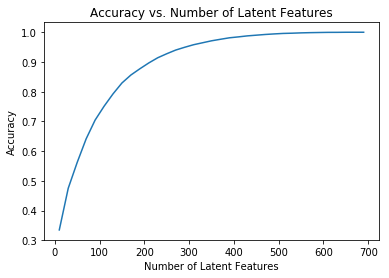

In [30]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  



In [31]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [32]:
df_train.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [33]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train=create_user_item_matrix(df_train)
    user_item_test=create_user_item_matrix(df_test)
    test_idx=user_item_test.index
    test_arts=user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

Checking how many users we can make predictions for that exist in both the train and the test dataframes:

In [34]:
total=0
for idx in test_idx:
    
    if idx in list(user_item_train.index):
         total+=1
print(total)

20


The Length of the test dataframe

In [35]:
len(test_idx)

682

The number of articles in the test dataframe

In [36]:
total=0
for art in test_arts:
    
    if art in list(user_item_train.columns):
         total+=1
print(total)

574


The total number of articles

In [37]:
len(test_arts)

574

## I had to change the dictionary keys to match in the test script. It said movies instead of articles

In [38]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now using the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then finding the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 



In [39]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [48]:
total_var = np.sum(s_train**2)# Total variability here
variability=[]
num_of_features=[]
for i in range(s_train.shape[0]):
    var_exp_comp1_and_compi = np.sum(s_train[:i]**2) # Variability Explained by the first two components here
    
    perc_exp = var_exp_comp1_and_compi/total_var * 100 # Percent of variability explained by the first two components here
    num_of_features.append(i)
    variability.append(perc_exp)
    # Run the below to print your results
    print("The total variance in the original matrix is {}.".format(total_var))
    print("Ther percentage of variability captured by the first {} components is {}%.".format(i,perc_exp))

The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 0 components is 0.0%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 1 components is 9.379199014504943%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 2 components is 11.077521546518621%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 3 components is 12.513782182587956%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 4 components is 13.851419765801587%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variability captured by the first 5 components is 15.107258484402495%.
The total variance in the original matrix is 28278.57342618131.
Ther percentage of variabili

After 360 features, the improvement is very slow. So we will take 400 as an arbitrary number of features

In [55]:
s_train.shape[0]

714

In [118]:
list_of_errors=[]

for p in range(2,714):
    
    u_train_2=u_train[:, :p]
    s_adjusted = np.zeros(p)
    s_adjusted = np.diag(s_train[:p]) 
    vt_train_2=vt_train[:p,:]

    #Getting predictions

    preds = np.dot(np.dot(u_train_2,s_adjusted),vt_train_2)

    #Converting it to a dataframe

    df_preds=pd.DataFrame(preds,index=user_item_train.index, columns=user_item.columns)

    # Converting the results to 0 and 1 since the prediction results are either a very small value or a value very close to 1

    preds_corrected=df_preds.applymap(lambda x: 0 if x<0.5 else 1) 

    # Getting the proportion of rows that are in the training set and test set from the predictions
    preds_corrected_subset=preds_corrected.loc[test_idx].iloc[:20,:]

    #Getting the proportion of rows from the training set
    df_train=user_item_train.loc[test_idx].iloc[:20,:]

    idx_test2=df_train.index

    df_test=user_item_test.loc[idx_test2].iloc[:20,:]

    # Calculating the sum square errors from the predictions and actual values from the original dataframe
    sum_square_errs = np.sum(np.sum((preds_corrected_subset-df_test )**2))
    list_of_errors.append(sum_square_errs)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [117]:
list_of_errors

[225.0,
 226.0,
 228.0,
 232.0,
 239.0,
 240.0,
 238.0,
 249.0,
 248.0,
 249.0,
 249.0,
 253.0,
 256.0,
 252.0,
 257.0,
 259.0,
 259.0,
 257.0,
 260.0,
 261.0,
 261.0,
 269.0,
 269.0,
 269.0,
 269.0,
 272.0,
 270.0,
 270.0,
 269.0,
 267.0,
 270.0,
 272.0,
 273.0,
 276.0,
 277.0,
 277.0,
 274.0,
 275.0,
 276.0,
 277.0,
 279.0,
 278.0,
 278.0,
 278.0,
 280.0,
 278.0,
 277.0,
 282.0,
 283.0,
 285.0,
 285.0,
 289.0,
 288.0,
 288.0,
 291.0,
 292.0,
 291.0,
 293.0,
 294.0,
 296.0,
 298.0,
 298.0,
 297.0,
 298.0,
 302.0,
 303.0,
 301.0,
 300.0,
 303.0,
 302.0,
 302.0,
 303.0,
 304.0,
 305.0,
 306.0,
 307.0,
 310.0,
 312.0,
 313.0,
 315.0,
 315.0,
 317.0,
 318.0,
 318.0,
 318.0,
 319.0,
 321.0,
 320.0,
 318.0,
 320.0,
 321.0,
 321.0,
 326.0,
 327.0,
 325.0,
 326.0,
 327.0,
 327.0,
 328.0,
 329.0,
 332.0,
 332.0,
 334.0,
 335.0,
 334.0,
 335.0,
 335.0,
 338.0,
 339.0,
 339.0,
 339.0,
 339.0,
 341.0,
 343.0,
 342.0,
 343.0,
 343.0,
 346.0,
 346.0,
 347.0,
 347.0,
 347.0,
 347.0,
 347.0,
 349.0,


In [111]:
k=u_train
k

array([[ -4.62841801e-02],
       [ -1.13343174e-02],
       [ -5.40077341e-02],
       [ -4.56589289e-02],
       [ -7.21876238e-03],
       [ -3.74866573e-02],
       [ -4.38205093e-03],
       [ -6.77352989e-02],
       [ -2.30152933e-02],
       [ -3.67048667e-02],
       [ -4.40932883e-02],
       [ -6.06589444e-03],
       [ -1.83044882e-02],
       [ -9.87655241e-03],
       [ -1.07952310e-02],
       [ -6.84347316e-03],
       [ -2.76340154e-02],
       [ -5.25857193e-03],
       [ -9.02414537e-03],
       [ -1.76545175e-03],
       [ -8.58539300e-02],
       [ -2.53045799e-02],
       [ -1.53833878e-01],
       [ -2.20184358e-02],
       [ -5.21257229e-03],
       [ -2.20789343e-02],
       [ -3.12074650e-02],
       [ -4.42506350e-02],
       [ -8.53351987e-04],
       [ -4.05001380e-03],
       [ -6.14455652e-03],
       [ -1.62683032e-02],
       [ -1.59084309e-02],
       [ -1.16599856e-02],
       [ -1.94301636e-02],
       [ -7.12577495e-03],
       [ -2.65652825e-02],
 

Lets see how many predictions we got:

In [58]:
list_of_errors

[]

In [46]:
preds_corrected_subset.sum(axis=1).sum()- df_test.sum(axis=1).sum()

35.0

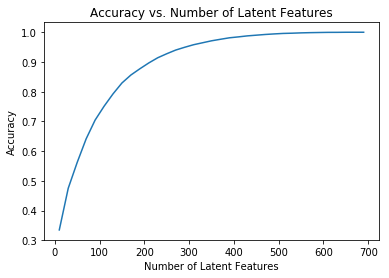

In [47]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

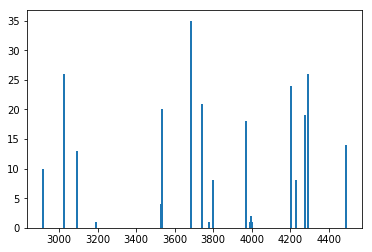

In [46]:
plt.bar(preds_corrected_subset.index,preds_corrected_subset.sum(axis=1),width=10);

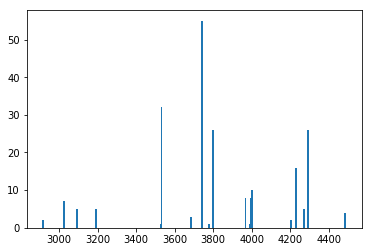

In [47]:
plt.bar(df_test.index,df_test.sum(axis=1),width=10);

**There seems to be a relationship between the number of recommendations and the number of user articles. If a certain user has a lot of articles, the model can predict more articles, while if there isn't a lot of viewed articles, the model seem to be inadequate.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 




## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0